# Problem Set #4

MACS 30000, Dr. Evans

Haihao Guo

## Exercise 1

In [1]:
import time

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.linalg as la

import warnings
warnings.filterwarnings("ignore")

beta = 0.96**20 
delta = 1 - (1 - 0.05)**20 
sigma = 3
A = 1
alpha = 0.35

nvec = np.array([1.0, 1.0, .2])
f_params = [nvec, A, alpha, delta]

def get_Y(K, L, alpha, A):
    return A * (K ** alpha) * (L ** (1-alpha))

def get_r(K, L, alpha, A, delta):
    r = (alpha * A * ((L / K) ** (1 - alpha))) - delta
    return r

def get_w(K, L, alpha, A): 
    w = (1 - alpha) * A * ((K / L) ** alpha) 
    return w

def get_K(b2, b3):
    return b2 + b3

def get_cons(b, b1, n, r, w):
    return w * n + (1 + r) * b - b1

def get_util(c, sigma):
    return (c ** (1-sigma))/(1-sigma)

def get_MU(c, sigma):
    return c ** (-sigma)

def feasible(f_params, bvec_guess):
    nvec, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = get_K(b2, b3)
    L = nvec.sum()
    r = get_r(K, L, alpha, A, delta)
    w = get_w(K, L, alpha, A)
    c1 = get_cons(0, b2, nvec[0], r, w)
    c2 = get_cons(b2, b3, nvec[1], r, w)
    c3 = get_cons(b3, 0, nvec[2], r, w)
    
    K_cnstr, c_cnstr, b_cnstr = np.full(1, False), np.full(3, False), np.full(2, False)
    
    c_cnstr[0] = c1 < 0 
    c_cnstr[1] = c2 < 0
    c_cnstr[2] = c3 < 0
    K_cnstr[0] = K < 0
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    if c_cnstr[2] == True:
        b_cnstr[1] = True
        
    return b_cnstr, c_cnstr, K_cnstr

ModuleNotFoundError: No module named 'scipy'

### A

In [4]:
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[ True False] [ True False False] [False]


Consumption nonnegativity constraint in period 1 is violated.

### B

In [5]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[False False] [False False False] [False]


No constraints is violated.

In [15]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[False False] [False False False] [False]


No constraints are violated.

## Exercise 2

In [6]:
def EulEqs(bvec, args):
    
    nvec, A, alpha, delta, beta, sigma = args
    b2, b3 = bvec
    
    L = nvec.sum()
    K = get_K(b2, b3)
    r = get_r(K, L, alpha, A, delta)
    w = get_w(K, L, alpha, A)
    c1 = get_cons(0, b2, nvec[0], r, w)
    c2 = get_cons(b2, b3, nvec[1], r, w)
    c3 = get_cons(b3, 0, nvec[2], r, w)
    mu1 = get_MU(c1,sigma)
    mu2 = get_MU(c2,sigma)
    mu3 = get_MU(c3,sigma)
    
    Eul1 = mu1 - beta*(1+r) * mu2
    Eul2 = mu2 - beta*(1+r) * mu3
    Euler_eqs = np.array([Eul1, Eul2])
    
    return Euler_eqs

def get_SS(params, bvec_guess, SS_graphs = False):
    
    start_time = time.clock()
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    args = np.array([nvec, A, alpha, delta, beta, sigma])
    b_ss = opt.root(EulEqs, bvec_guess, tol=SS_tol, args = args).x
    
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(K_ss, L, alpha, A, delta)
    Y_ss = get_Y(K_ss, L, alpha, A)
    w_ss = get_w(K_ss, L, alpha, A)
    c1 = get_cons(0, b2, nvec[0], r_ss, w_ss)
    c2 = get_cons(b2, b3, nvec[1], r_ss, w_ss)
    c3 = get_cons(b3, 0, nvec[2], r_ss, w_ss)
    c_ss = np.array([c1, c2, c3])
    C_ss = c_ss.sum()
    EulErr_ss = EulEqs(b_ss, args)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock() - start_time
    
    ss_output = {
    'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    
    if SS_graphs:
        x = np.arange(3)
        plt.bar(x, c_ss)
        plt.xticks(x, ('C1', 'C2', 'C3'))
        plt.title('Steady-state distribution of consumption')
        plt.show()
        y = np.arange(2)
        plt.bar(y, b_ss)
        plt.xticks(y, ('b2', 'b3'))
        plt.title('Steady-state distribution of savings')
        plt.show()
    return ss_output

### A

In [8]:
SS_tol = 1e-10
params = [beta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
get_SS(params, bvec_guess)

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([-1.33582034e-12,  2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0006539999999999324}

It took 0.00065 seconds to compute the steady state.

### B

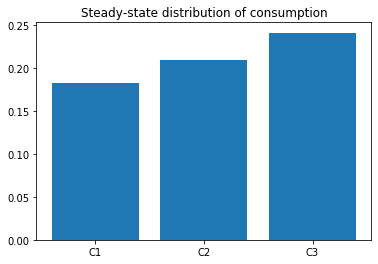

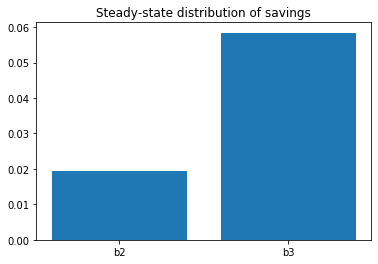

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([-1.33582034e-12,  2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0007669999999999622}

In [9]:
get_SS(params, bvec_guess,SS_graphs = True)

### C

In [10]:
params2 = [0.55, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol]
get_SS(params2, bvec_guess)

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003315,
 'r_ss': 1.8863599991452351,
 'K_ss': 0.10504252550764615,
 'Y_ss': 0.7586693633878046,
 'C_ss': 0.6912831045288896,
 'EulErr_ss': array([-2.84217094e-14, -2.84217094e-14]),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0004799999999998139}

When $\beta$ becomes larger, the steady-state level of wage, saving and consumption in each period are higher and the interest rate is lower. Intuitively, high $\beta$ means the consumers put more emphasis on the later periods. Thus, people would save more to optimize their lifetime utility. When the saving is higher, there is more capital, interest rate becomes lower. Thus, marginal productivity of labor is higher and wage is larger. The overall income level of consumers is higher, and in this case, the income effect is larger than substitution effect. Consumption in each period increase.

## Exercise 3

In [11]:
L = sum(nvec)
T = 20
tol = 1e-9
xi = 0.2
eul_tol = 1e-6  
max_iter = 10000
params3 = [beta, sigma, nvec, L, A, alpha, delta, eul_tol]

b_ss = get_SS(params, bvec_guess)['b_ss']
b2bar,b3bar = b_ss[0],b_ss[1]
b_ss = np.array([b2bar, b3bar])

b21 = 0.8 * b2bar
b31 = 1.1 * b3bar
bvec_guess = np.array([b21, b31])

K1 = b21 + b31
Kbar = b2bar + b3bar
Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, Kbar)

def get_path(T, Kpath, Kbar, params):
    
    rpath = np.zeros(T)
    wpath = np.zeros(T)
    for t in range(T):
        rpath[t] = get_r(Kpath[t], L, alpha, A, delta)
        wpath[t] = get_w(Kpath[t], L, alpha, A)
    rbar = get_r(Kbar, L, alpha, A, delta)
    wbar = get_w(Kbar, L, alpha, A)
    rpath = np.append(rpath, rbar)
    wpath = np.append(wpath, wbar)
    
    return np.array([rpath, wpath])

def EulEqs2(b32, b32_params):
    
    b21,b22,rpath,wpath,params = b32_params[0],b32_params[1],b32_params[2],b32_params[3],b32_params[4]
    c1 = get_cons(b21, b32, params[2][1], rpath[0], wpath[0])
    u1 = get_MU(c1, sigma)
    c2 = get_cons(b32, 0, params[2][2], rpath[1], wpath[1])
    u2 = get_MU(c2, sigma)
    
    return u1 - params[0] * (1 + rpath[1]) * u2


def get_b32(b21, b22, rpath, wpath, params, bvec_guess):
    
    b32_params = [b21, b22, rpath, wpath, params]
    result = opt.root(EulEqs2,bvec_guess[0],args = b32_params, tol = params[7])
    b32 = result.x
    b32_EulErrs = result.fun
    
    return np.array([b32, b32_EulErrs])

def get_cons(b, b1, n, r, w):
    return w * n + (1 + r) * b - b1

def get_b_EulErr(b, b_params):
    
    t, rpath, wpath, params = b_params[0],b_params[1],b_params[2],b_params[3]
    
    c21 = get_cons(0,  b[0], params[2][0], 0, wpath[t])
    u21 = get_MU(c21, sigma)
    c22 = get_cons(b[0], b[1], params[2][1], rpath[t+1], wpath[t+1])
    u22 = get_MU(c22, sigma)
    b2_EulErr = u21 - params[0] * (1 + rpath[t+1]) * u22
    
    c31 = get_cons(b[0], b[1], params[2][1], rpath[t+1], wpath[t+1])
    u31 = get_MU(c31, sigma)
    c32 = get_cons(b[1], 0, params[2][2], rpath[t+2], wpath[t+2])
    u32 = get_MU(c32, sigma)
    b3_EulErrs = u31 - params[0] * (1 + rpath[t+2]) * u32
    
    return np.array([b2_EulErr, b3_EulErrs])


def get_b(t, rpath, wpath, params, bvec_guess):
    
    b_params = [t, rpath, wpath, params]
    result = opt.root(get_b_EulErr, bvec_guess, args = b_params, tol = params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])

def get_errs(Kpath, rpath, wpath, bmat, params):
    
    L = params[2].sum()
    C = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
    Y = params[4] * (Kpath[:-1]**params[5]) * L**(1 - params[5])
    agg_err = Y - C - Kpath[1:] + (1 - params[6]) * Kpath[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err

def get_result(T, rpath, wpath, Kpath, bvec_guess, b_ss, params):
    
    bmat = np.zeros((T+1, 2))
    bmat[0,:] = bvec_guess
    EulErrs = np.zeros((T+1, 2))
    cols = [0,1]
    for t in range(T-1):
        rows = [t+1, t+2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, rpath, wpath,params,bvec_guess)
    bmat[1,1], EulErrs[1,1] = get_b32(bmat[0,0], bmat[0,1], rpath, wpath, params, bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis = 0)
    agg_errs = get_errs(Kpath, rpath, wpath, bmat, params)
    
    return bmat, max_EulErrs, agg_errs

def Kprime(bmat, Kbar):
    
    Kp_path = bmat[:-1,:].sum(axis = 1)
    Kp_path = np.append(Kp_path, Kbar)
    
    return Kp_path

def TPI(T, Kpath, Kbar, bvec_guess, b_ss, params, tol, max_iter):
    
    dist = 1e9
    i = 0
    
    while (dist > tol) & (i < max_iter):
        i += 1
        rpath, wpath = get_path(T, Kpath, Kbar, params)
        bmat, max_EulErrs, max_agg_errs = get_result(T, rpath, wpath, Kpath, bvec_guess, b_ss, params)
        Kp_path = Kprime(bmat, Kbar)
        dist = la.norm(Kp_path - Kpath, 2)
        Kpath = xi * Kp_path + (1 - xi) * Kpath
    
    print('Max absolute Euler errors: ', (max_EulErrs[0],max_EulErrs[1]))
    print('Max absolute aggregate resources constraint error:', max_agg_errs)
    
    return Kpath, rpath, wpath

### A

In [12]:
K, r, w = TPI(T, Kpath, Kbar, bvec_guess, b_ss, params3, tol, max_iter)

Max absolute Euler errors:  (3.2134150274032436e-07, 9.464268657666253e-08)
Max absolute aggregate resources constraint error: 0.019312759519526906


### B

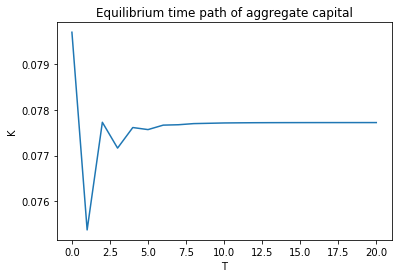

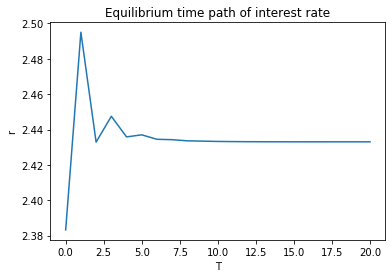

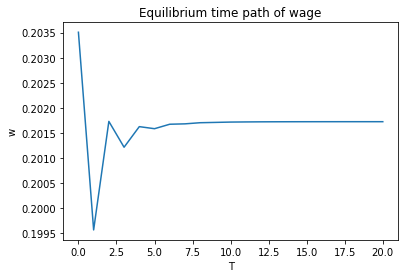

In [13]:
plt.plot(K)
plt.title('Equilibrium time path of aggregate capital')
plt.xlabel('T')
plt.ylabel('K')
plt.show()

plt.plot(r)
plt.title('Equilibrium time path of interest rate')
plt.xlabel('T')
plt.ylabel('r')
plt.show()

plt.plot(w)
plt.title('Equilibrium time path of wage')
plt.xlabel('T')
plt.ylabel('w')
plt.show()

### C

In [14]:
K_dist = np.abs(K - Kbar)
err = 1e-5
loc = np.where(K_dist < err)[0]
print('Number of periods taken by the economy to get within 1e-5 of the steady state aggregate capital: ', loc.min())
loc2 = np.ediff1d(loc) == 1
print('Number of periods from which the economy stays within 1e-5 of the steady state aggregate capital: ', loc[-len(loc2)])

Number of periods taken by the economy to get within 1e-5 of the steady state aggregate capital:  2
Number of periods from which the economy stays within 1e-5 of the steady state aggregate capital:  10
